# Every data science project's full pipeline on the example of House Prices data.

<i>Enjoy your reading</i>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

In [3]:
def less_values(frame, percentile):
    """
    Checks which columns have more than certain number of missing values and drops them.
    """
    df = frame
    for col in df.columns:
        count = df[col].count()
        if count < 1460*float(percentile):
            df.drop(col, axis=1, inplace=True)
    
    return df

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
path = r'C:\Users\Gev\Desktop\Data science\house-prices-advanced-regression-techniques\files\train.csv'
df = pd.read_csv(path, index_col = 0)

## 1.0 Understanding business problem <br>2.0 Data collection

As data is taken from [kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques), I'll skip this 2 steps.

In [6]:
# Blank page

## 3.0 Data preporation

In [7]:
import category_encoders as ce
from sklearn.impute import SimpleImputer

In [8]:
# Some columns have an integer data type, while they are categorical.
# For future convenience, I'll change the data type to object

for col in ['MSSubClass','OverallQual', 'OverallCond']:
    df[col] = df[col].astype('object')

In [9]:
# As there are some columns with insignificant amount of values
df = less_values(frame=df, percentile=0.8)

In [10]:
# I want to focus more on continuous and categorcical data, so I'll just drop inforamtion about date
date = np.array(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'])
df = df.drop(date, axis = 1)

In [11]:
# Define numerical data columns
num_cols = np.array(df.select_dtypes(include=['int64', 'float64']).columns)
num_cols = np.delete(num_cols, len(num_cols) - 1) # Removing SalePrice i.e target

# Define categorical data columns
cat_cols = np.array(df.select_dtypes(include=['object']).columns)

In [12]:
# Since I want to use imputers and encoders, I need train data to fit them
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:, -1], test_size=.3, random_state=42)

### 3.1 Imputers: handling missing values

##### Numerical features

In [13]:
num_transformer = SimpleImputer(strategy='median', missing_values=np.nan)
X_train[num_cols] = num_transformer.fit_transform(X_train[num_cols])
print('Missing values: {}'.format(X_train[num_cols].isnull().any().any()))

Missing values: False


In [14]:
X_test[num_cols] = num_transformer.transform(X_test[num_cols])
print('Missing values: {}'.format(X_test[num_cols].isnull().any().any()))

Missing values: False


##### Categorical features

In [15]:
cat_imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
print('Missing values: {}'.format(X_train[cat_cols].isnull().any().any()))

Missing values: False


In [16]:
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])
print('Missing values: {}'.format(X_test[cat_cols].isnull().any().any()))

Missing values: False


### 3.2 Enocoders
I'll use 2 different encoders. Which one is better I already know, but I want to show the difference.

##### Target encoder

In [17]:
t_encoder = ce.TargetEncoder(cols=cat_cols)

In [18]:
X_train_target = X_train.copy()
X_train_target[cat_cols] = t_encoder.fit_transform(X_train[cat_cols], y_train)
X_train_target[cat_cols[0:5]].head(1) # Checking the results

,MSSubClass,MSZoning,Street,LotShape,LandContour
Id,,,,,
136,185972.761905,191179.183395,181392.359528,166232.913793,180203.52694


In [19]:
X_test_target = X_test.copy()
X_test_target[cat_cols] = t_encoder.transform(X_test[cat_cols])
X_test_target[cat_cols[0:5]].head(1)

,MSSubClass,MSZoning,Street,LotShape,LandContour
Id,,,,,
893,185972.761905,191179.183395,181392.359528,166232.913793,180203.52694


##### [GLMM](https://contrib.scikit-learn.org/category_encoders/glmm.html) encoder

In [20]:
glmm = ce.glmm.GLMMEncoder()

In [21]:
X_train_glmm = X_train.copy()
X_train_glmm[cat_cols] = glmm.fit_transform(X_train[cat_cols], y_train)
X_train_glmm[cat_cols[5:10]].head(1)

,Utilities,LotConfig,LandSlope,Neighborhood,Condition1
Id,,,,,
136,5.34905,-11505.913207,-12349.133981,4255.83867,9521.750105


In [22]:
X_test_glmm = X_test.copy()
X_test_glmm[cat_cols] = glmm.transform(X_test[cat_cols])
X_test_glmm[cat_cols[5:10]].head(1)

,Utilities,LotConfig,LandSlope,Neighborhood,Condition1
Id,,,,,
893,5.34905,-11505.913207,-12349.133981,-46765.19153,9521.750105


In [23]:
# Blank page

## 4.0 Data exploration

I already done data exploration im my previous notebooks. You can find them in my [github](https://github.com/GevHovh/my_resume).

In [24]:
# Blank page

## 5.0 Feature selection

For feature selection I'll use SelectKBest from sklearn package. In my draft notebook I tried other methods(like Linear Regression with looking at coefficients, and SelectFromModel from sklearn package with Lasso, but they showed worse results.

In [25]:
from sklearn.feature_selection import SelectKBest, f_regression

In [26]:
selector = SelectKBest(f_regression, k=45) # I have found out best k simply by trial and error

In [27]:
X_train_new = selector.fit_transform(X_train_target, y_train)
X_train_new = pd.DataFrame(selector.inverse_transform(X_train_new),
                          index=X_train.index,
                          columns=X_train.columns)
selected_columns_target = X_train_new.columns[X_train_new.var() != 0]

In [28]:
print('First 5 features from target encoded data: {}'.format(list(selected_columns_target[:5])))

First 5 features from target encoded data: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape']


In [29]:
X_train_new = selector.fit_transform(X_train_glmm, y_train)
X_train_new = pd.DataFrame(selector.inverse_transform(X_train_new),
                          index=X_train.index,
                          columns=X_train.columns)
selected_columns_glmm = X_train_new.columns[X_train_new.var() != 0]

In [30]:
print('First 5 features from glmm encoded data: {}'.format(list(selected_columns_glmm[:5])))

First 5 features from glmm encoded data: ['MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour']


In [31]:
# Blank page

## 6.0 Model selection

I considered three models:<br>
1) Simple Linear regression <br>
2) Random forest <br>
3) XGBoost regression <br>

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [33]:
reg = LinearRegression()
forest = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

In [34]:
models = {'Linear Regression': reg,
         'Random Forest': forest,
         'XGB Regression': xgb}

In [35]:
# For future cross validation I'll use all data I have
all_target = pd.concat((X_train_target, X_test_target))
all_glmm = pd.concat((X_train_glmm, X_test_glmm))
all_y = pd.concat((y_train, y_test))

In [36]:
results = {}
target_means = []
glmm_means = []

for i in models:
    # Calculating cross validation scores and mean for target encoded data
    models[i].fit(X_train_target[selected_columns_target], y_train)
    t_score = cross_val_score(models[i], all_target[selected_columns_target], all_y, scoring='neg_mean_absolute_error', cv=3)
    t_score = -1 * t_score
    t_score = np.round(t_score, 1)
    t_mean = np.round(t_score.mean(), 1)
    t_score = ('targer score', t_score, t_mean)
    target_means.append(t_mean)
    
    # Calculating cross validation scores and mean for glmm encoded data
    models[i].fit(X_train_glmm[selected_columns_glmm], y_train)
    glmm_score = cross_val_score(models[i], all_glmm[selected_columns_glmm], all_y, scoring='neg_mean_absolute_error', cv=3)
    glmm_score = -1 * glmm_score
    glmm_score = np.round(glmm_score, 1)
    glmm_mean = np.round(glmm_score.mean(), 1)
    glmm_score = ('glmm score', glmm_score, glmm_mean)
    glmm_means.append(glmm_mean)
    
    # score
    score = [t_score, glmm_score]
    results[i] = score

In [37]:
sns.set_style('whitegrid')

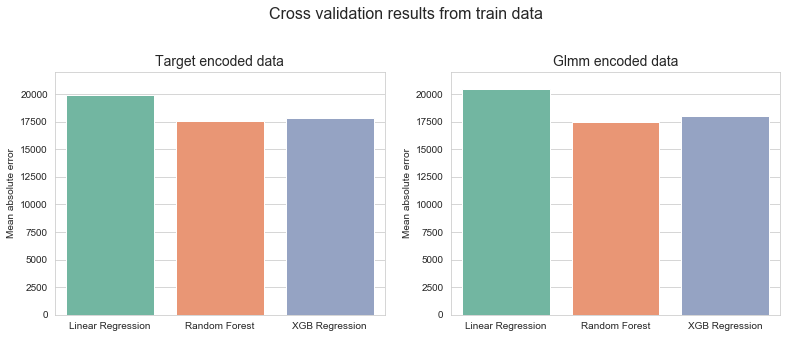

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13, 5))
plt.subplots_adjust(top=0.80)
fig.suptitle('Cross validation results from train data', fontsize=16)

x_axis = list(models.keys())
ax1 = sns.barplot(x=x_axis, y=target_means, palette='Set2', ax=ax1)
ax1.set_title('Target encoded data', fontsize=14)
ax1.set_ylim((0, 22000))
ax1.set_ylabel('Mean absolute error')

ax2 = sns.barplot(x=x_axis, y=glmm_means, palette='Set2', ax=ax2)
ax2.set_title('Glmm encoded data', fontsize=14)
ax2.set_ylim((0, 22000))
ax2.set_ylabel('Mean absolute error')


plt.show()

In [39]:
# More detailed
for key in results:
    print(key + ':')
    print(results[key])
    
    if key == 'XGB Regression':
        print('_'*125)
    else:
        print('\n')

Linear Regression:
[('targer score', array([20763.4, 18547.8, 20309.1]), 19873.4), ('glmm score', array([21569.8, 19204.2, 20561.4]), 20445.1)]


Random Forest:
[('targer score', array([20092. , 16264.1, 16263.6]), 17539.9), ('glmm score', array([20023. , 16321.6, 15935.7]), 17426.8)]


XGB Regression:
[('targer score', array([19709.8, 17089.5, 16596. ]), 17798.4), ('glmm score', array([19761.3, 17045. , 17221. ]), 18009.1)]
_____________________________________________________________________________________________________________________________


##### We can see from the above, that Random Forest and  XGB Regression algorithms show better results. But to make sure about my choice, I'll evaluate them on test data.

In [40]:
def train_model(model, X_train, X_test, y_train=y_train, y_test=y_test):
    """
    Fitting model, and scoring with mean absolute error
    """
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = mean_absolute_error(y_test, pred)
    return score

In [41]:
test_target = []
test_glmm = []

for i in models:
    # Calculating mean absolute error for target encoded data
    score = train_model(models[i], X_train_target[selected_columns_target], X_test_target[selected_columns_target])
    score = np.round(score, 1)
    test_target.append(score)
    
    # Calculating mean absolute error for glmm encoded data
    score = train_model(models[i], X_train_glmm[selected_columns_glmm], X_test_glmm[selected_columns_glmm])
    score = np.round(score, 1)
    test_glmm.append(score)

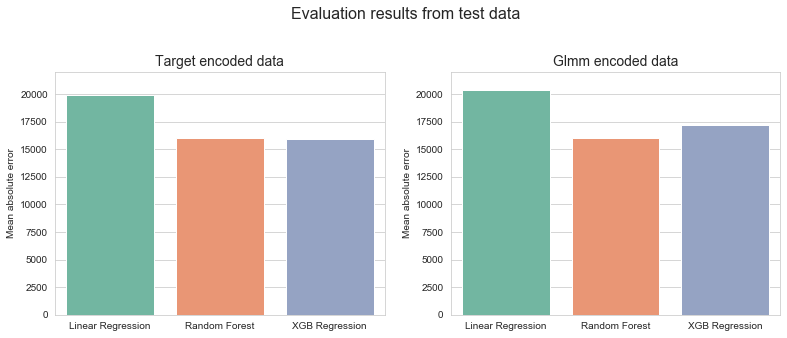

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13, 5))
plt.subplots_adjust(top=0.8)
fig.suptitle('Evaluation results from test data', fontsize=16)

x_axis = list(models.keys())
ax1 = sns.barplot(x=x_axis, y=test_target, palette='Set2', ax=ax1)
ax1.set_title('Target encoded data', fontsize=14)
ax1.set_ylim((0, 22000))
ax1.set_ylabel('Mean absolute error')

ax2 = sns.barplot(x=x_axis, y=test_glmm, palette='Set2', ax=ax2)
ax2.set_title('Glmm encoded data', fontsize=14)
ax2.set_ylim((0, 22000))
ax2.set_ylabel('Mean absolute error')

plt.show()

In [43]:
# More detailed
for i in range(3):
    print(x_axis[i] + ':')
    print('  Target encoded data: ' + str(test_target[i]))
    print('  Glmm encoded data: ' + str(test_glmm[i]))
    
    if i == 2:
        print('_'*125)
    else:
        print('\n')

Linear Regression:
  Target encoded data: 19903.2
  Glmm encoded data: 20340.3


Random Forest:
  Target encoded data: 16044.4
  Glmm encoded data: 16038.6


XGB Regression:
  Target encoded data: 15951.0
  Glmm encoded data: 17152.1
_____________________________________________________________________________________________________________________________


##### From the barplots it becomes clear that Random Forest shows more accurate results on average. Further, I'll use glmm data as in my draft notebook it shows better results.

In [44]:
# Blank page

## 7.0 Model deployment

I'll not show the whole process of tunning hyperparameters with GridSearchCV from sklearn package. But here what I found:<br><br>
• With more <i>n_estimators</i> the model predicts more accurate, which is obvious, but that improvement  isn't significant (about 100-300\$ in the case of absolute error). So I decided to use 1000 estimators for more convenience.<br>
• <i>max_depth</i> and <i>min_samples_leaf</i>: As these two parameters are related to each other I changed only one - <i>min_samples_leaf</i>. GridSearchCV showed that the optimal value for this parameter is 1, but common sense tells that it will cause overfitting, so I'll use <i>min_samples_leaf=2</i>.<br>
• <i>max_features</i>: I'll use the best result from GridSearchCV - 'sqrt'<br>
• Other parameters will be default.
<br><br>
Thus, final parametrs will be:<br><br>
<b>n_estimators</b> = 1000<br>
<b>min_samples_leaf</b> = 2<br>
<b>max_features</b> = 'sqrt'

In [45]:
X_train_new = X_train_glmm[selected_columns_glmm]
X_test_new = X_test_glmm[selected_columns_glmm]

In [46]:
forest = RandomForestRegressor(n_estimators=1000,
                              min_samples_leaf=2,
                              max_features='sqrt',
                              oob_score=True,
                              n_jobs=4,
                              random_state=42)

In [47]:
forest.fit(X_train_new, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=4, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [48]:
pred = forest.predict(X_test_new)

In [49]:
from sklearn.metrics import r2_score

In [50]:
error = mean_absolute_error(y_test, pred)
error = np.round(error, 0)

r2 = r2_score(y_test, pred)
r2 = np.round(r2, 2)

oob = forest.oob_score_
oob = np.round(oob, 2)

In [51]:
# More detailed metrics
pd.DataFrame(index=['Mean absolute error', 'R^2', 'Out-of-bag'], columns=['Random Forest'], data=[error, r2, oob])

,Random Forest
Mean absolute error,16071.00
R^2,0.90
Out-of-bag,0.84


In [52]:
# Blank page

## 8.0 Results visualization

In [53]:
x = np.arange(0, 800001, 100000)

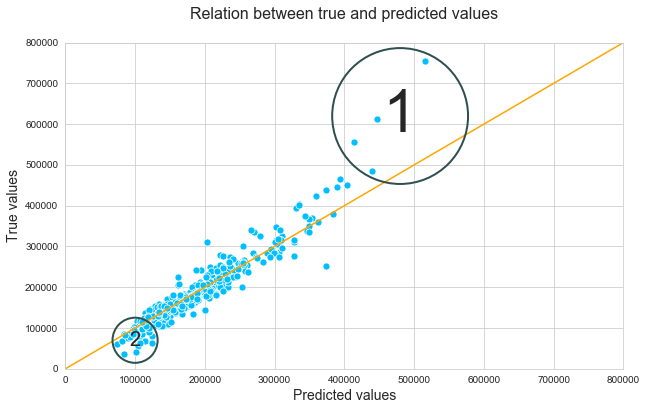

In [54]:
plt.figure(figsize=(10,6))

sns.lineplot(x=x, y=x, color='orange')
sns.scatterplot(y=y_test, x=pred, color='deepskyblue', s=50)

plt.xlim(0,800000)
plt.ylim(0,800000)
plt.title('Relation between true and predicted values\n', fontsize=16)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('True values', fontsize=14)

plt.text(100000, 70000, '  2  ', ha="center", va="center", rotation=0, size=20,
    bbox=dict(boxstyle="circle,pad=0.3", lw=2, color='darkslategray', fill=False))
plt.text(480000, 620000, '  1  ', ha="center", va="center", rotation=0, size=60,
    bbox=dict(boxstyle="circle,pad=0.3", lw=2, color='darkslategray', fill=False))

plt.show()

#### With this kind of a plot we expect dots to be closer to the yellow line(45 degree), which will indicate that our predictions match with true values. But, as we can see, there are some problem zones(circles). <i>Circle 1</i> includes predictions with high absolute errors(see the table below). In contrast to that, <i>Circle 2</i> includes values with high percentage errors(see the table below). 

In [55]:
pred_table = pd.DataFrame({'True values': y_test,
             'Predicted values': pred}, 
            index=y_test.index)

In [56]:
pred_table['Absolute'] = pred_table['True values'] - pred_table['Predicted values']
pred_table['Absolute'] = pred_table['Absolute'].apply('abs')
pred_table['Percentage'] = pred_table['Absolute'] / pred_table['True values']

All credits for this function goes to [this guy](https://towardsdatascience.com/highlighting-columns-in-pandas-dataframe-bf2ff77d00bc).

In [57]:
def highlight_columns(df, rows=20, color='lightgreen', columns_to_highlight=[], columns_to_show=[]):
    """
    Highlights selected columns of dataframe
    """
    highlight = lambda slice_of_df: 'background-color: %s' % color
    sample_df = df.head(rows)
    if len(columns_to_show) != 0:
        sample_df = sample_df[columns_to_show]
    highlighted_df = sample_df.style.applymap(highlight, subset=pd.IndexSlice[:, columns_to_highlight])
    return highlighted_df

#### 10 objects with the highest absolute errors

In [58]:
abs_error = pred_table.sort_values(by='Absolute', ascending=False)
highlight_columns(abs_error[:10], columns_to_highlight=['Absolute'])

,True values,Predicted values,Absolute,Percentage
Id,,,,
692,755000,515561.833615,239438.166385,0.317137
899,611657,446847.055958,164809.944042,0.269448
1047,556581,413208.063136,143372.936864,0.257596
582,253293,373632.896799,120339.896799,0.475102
219,311500,202957.132800,108542.867200,0.348452
378,340000,266070.851533,73929.148467,0.217439
1244,465000,393732.449814,71267.550186,0.153264
232,403000,335088.958379,67911.041621,0.168514
662,402000,334725.705035,67274.294965,0.167349


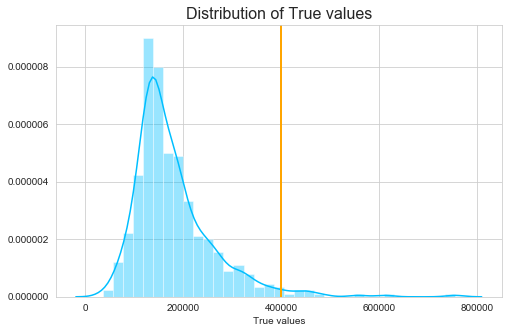

In [59]:
plt.figure(figsize=(8,5))

sns.distplot(abs_error['True values'], color='deepskyblue')
plt.axvline(x=400000, color='orange', linewidth = 2)
plt.title('Distribution of True values', fontsize=16)

plt.show()

##### It can be noticed from the table above, that most objects have True values more than 400000. It indicates, that algorithm mostly makes mistakes with extremely high True values.

In [60]:
# Blank page

#### 10 objects with the highest percentage errors

In [61]:
prc_error = pred_table.sort_values(by='Percentage', ascending=False)
highlight_columns(prc_error[:10], columns_to_highlight=['Percentage'])

,True values,Predicted values,Absolute,Percentage
Id,,,,
31,40000,101668.313656,61668.313656,1.541708
917,35311,83430.099111,48119.099111,1.362723
463,62383,123629.207443,61246.207443,0.981777
813,55993,104598.760274,48605.760274,0.868069
1280,68400,114487.651062,46087.651062,0.673796
1433,64500,106795.323990,42295.323990,0.655741
399,67000,108833.949573,41833.949573,0.624387
875,66500,106732.001707,40232.001707,0.604993
1062,81000,124305.297537,43305.297537,0.534633


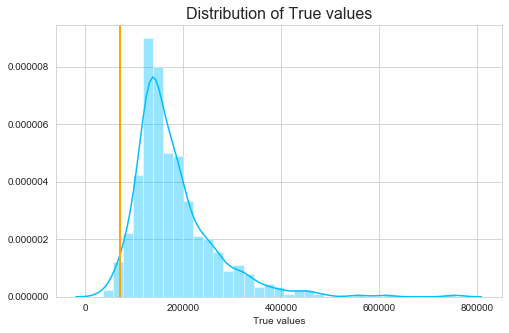

In [62]:
plt.figure(figsize=(8,5))

sns.distplot(abs_error['True values'], color='deepskyblue')
plt.axvline(x=70000, color='orange', linewidth = 2)
plt.title('Distribution of True values', fontsize=16)

plt.show()

##### Conversely, here we can see, that objects with high percentage errors are those, which have relatively low prices.

In [63]:
# Blank page

## Summary

Apparently, the reason why Random Forest couldn't explain target variance well is its proclivity to overfeeting. If I look at these problem objects, and explore their features more deeply, maybe I'll find the actual reason of their extreme prices and I will be able to fix model to detect those extreme reasons.

But it is a topic for another talk.<br>
<i>Thank you for your time.</i>